In [1]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, pooling, SimpleRNN, LSTM, BatchNormalization
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn import model_selection, metrics
from WordDictionary import WordDictionary
import json
import numpy as np
import math

print('Loading complete!')

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


Loading complete!


In [2]:
def d_2d_to_3d(x, add_one_dim = True):
    shape_size = math.ceil(math.sqrt(max_words))
    len_x = len(x)
    x3d = []
    for i in range(len_x):
        row = x[i]
        zero_arr = np.zeros(shape_size * shape_size)
        zero_arr[:len(row)] += row
        if add_one_dim:
            zero_arr = zero_arr.reshape([shape_size, shape_size, 1])
        else:
            zero_arr = zero_arr.reshape([shape_size, shape_size])
        x3d.append(zero_arr)
        
    return np.array(x3d)

사용 데이터
==========
- ISEAR데이터 ('Anger', 'Hate', 'Fear', 'Sorry', 'Joy', 'Neutral', 'Sadness', 'Shame' 8가지 감정)
- 영어로 구성된 문장
- 10라인을 하나의 데이터 단위로 사용

전처리
====
__[한글_KoNLPy]__
- Okt형태소 분석기를 사용
- 조사, 어미, 구두점, 특수기호, 외국어 및 한글자로 되어있는 단어 제외

__[영어_NLTK]__
- Stemming(어간추출, 형태소 분석)
    * 어간 추출은 어형이 변형된 단어로부터 접사 등을 제거하고 그 단어의 어간을 분리해 내는 것
    * "message", "messages", "messaging" 과 같이 복수형, 진행형 등의 문자를 같은 의미의 단어로 다룰 수 있도록 도와준다.
- Lemmatization(음소 표기법)
    * 단어의 보조 정리 또는 사전 형식에 의해 식별되는 단일 항목으로 분석 될 수 있도록 굴절 된 형태의 단어를 그룹화 하는 과정. 
    * 쉽게 말해서 단어의 원형(lemma)를 찾는 것
- stopword(불용어) 제거
    * 빈번하게 등장하지만 실제 의미를 찾는데 큰 기여를 하지 않는 단어 (i, me, my, it, this, that, is, are 등)
    
임베딩
====
CNN모델의 입력 데이터로 사용하기 위해서 형태소 분석된 문장의 단어들을 __전체 단어수의 제곱근을 올림 한 값__ 으로 크기를 잡은 2차원 배열에 표시한다.
올림으로 인해서 남는 배열 공간은 __padding(0)__ 으로 채운다.

    ex) "집에서 키우는 강아지가 죽었다. 정이 많이 들었던 강아지였는데 너무 슬퍼서 눈물이 난다."
        
        * 형태소 분석 :    ('집', 'Noun')
                        ('키우는', 'Verb')
                        ('강아지', 'Noun')
                        ('죽었다', 'Verb')
                        ('정이', 'Noun')
                        ('많이', 'Adverb')
                        ('들었던', 'Verb')
                        ('강아지', 'Noun')
                        ('였는데', 'Verb')
                        ('너무', 'Adverb')
                        ('슬퍼서', 'Adjective')
                        ('눈물', 'Noun')
                        ('난다', 'Verb')
                    
        * Tokenizing : {'집' : 0, 
                        '키우는 : 1,
                        '강아지 : 2,
                        '죽었다' : 3,
                        '정이' : 4,
                        '많이' : 5,
                        '들었던' : 6,
                        '강아지' : 2,
                        '였는데' : 7,
                        '너무' : 8,
                        '슬퍼서' : 9,
                        '눈물' : 10,
                        '난다' : 11}
                        
        * max word size : 12
        * shape size : 4
                        
        * Word Embedding : 4 by 4 2dimension matrix
                        [[1, 1, 2, 1],
                         [1, 1, 1, 1],
                         [1, 1, 1, 1],
                         [0, 0, 0, 0]]

In [3]:
MAX_LINE_CNT = 10

wordDictionary = WordDictionary()
wordDictionary.Load(MAX_LINE_CNT, 'en')

max_words = wordDictionary.GetDictionaryCnt()
nb_classes = 8
batch_size = 64
nb_epoch = 10
language = 'en'

data = json.load(open("emotionData/data_{0}_line_{1}.json".format(MAX_LINE_CNT, language)))
X = data["X"]
Y = data["Y"]

WordDictionary load complete!


In [18]:
emotion_str_arr = ['Anger', 'Hate', 'Fear', 'Sorry', 'Joy', 'Neutral', 'Sadness', 'Shame']

cnt_list = []
for i in range(8):
    cnt_list.append(0)

sum_dic = {}
    
for label in Y:
    cnt_list[label] += 1
    
for i in range(len(cnt_list)):
    print(emotion_str_arr[i],"cnt :", cnt_list[i])
    

Anger cnt : 120
Hate cnt : 241
Fear cnt : 955
Sorry cnt : 108
Joy cnt : 1192
Neutral cnt : 864
Sadness cnt : 708
Shame cnt : 107


In [5]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

Y_train = np_utils.to_categorical(Y_train, nb_classes)
Y_test = np_utils.to_categorical(Y_test, nb_classes)
print(len(X_train), len(Y_train))

X_train = np.array(X_train)
X_test = np.array(X_test)

s = np.arange(X_train.shape[0])
np.random.shuffle(s)

X_train = X_train[s]
Y_train = Y_train[s]

X_train = d_2d_to_3d(X_train)
X_test = d_2d_to_3d(X_test)

3221 3221


In [6]:
print("MaxWords : ",max_words)
print("Data shape : ", X_train[:1].shape)

MaxWords :  37624
Data shape :  (1, 194, 194, 1)


In [7]:
size = math.ceil(math.sqrt(max_words))

model = Sequential()
model.add(Conv2D(32, 3, 3, input_shape=(size, size, 1), activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(pooling.MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch,validation_split=0.2)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(194, 194,..., activation="relu")`
  after removing the cwd from sys.path.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 192, 192, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 94, 94, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 47, 47, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 47, 47, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 70688)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               9048192   
__________

In [8]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
'''
y = model.predict(X_test)
ac_score = metrics.accuracy_score(Y_test, y)
cl_report = metrics.classification_report(Y_test, y)

print("정답률 =", ac_score)
print("리포트 =", cl_report)
'''

1074/1074 [==============================] - 16s 15ms/step
Test set
  Loss: 0.158
  Accuracy: 0.951


'\ny = model.predict(X_test)\nac_score = metrics.accuracy_score(Y_test, y)\ncl_report = metrics.classification_report(Y_test, y)\n\nprint("정답률 =", ac_score)\nprint("리포트 =", cl_report)\n'

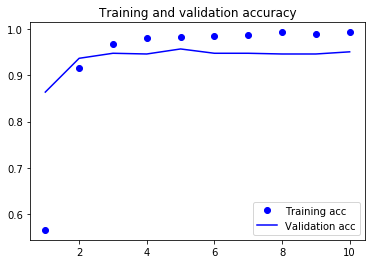

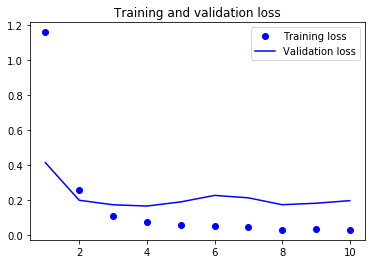

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
TEST_SENTENCE = 'I was sorry to yell at my mom. I did not do well, and my injured mother cried. I want to apologize.'

X_input = wordDictionary.GetInputData(TEST_SENTENCE, prev_language='en')
X_input = np.array(X_input)
X_input = X_input.reshape(1, X_input.size)
X_input = d_2d_to_3d(X_input)

y = model.predict(X_input)
print("예측 = ", emotion_str_arr[np.argmax(y[0])])

Get index/word 245 sorri
Get index/word 1290 yell
Get index/word 742 mom
Get index/word 754 well
Get index/word 3260 injur
Get index/word 104 mother
Get index/word 563 cri
Get index/word 431 want
Get index/word 2119 apolog
[245, 1290, 742, 754, 3260, 104, 563, 431, 2119]
37624
예측 =  Sadness
